In [3]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd 
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import torch
import re


In [4]:
print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = False
torch.cuda.device_count() = 0


In [5]:
dataset_path=r"data\images\google_images"

In [6]:
labels_dict = dict(
   img_path=[],  
    xmin=[], 
    xmax=[], 
    ymin=[], 
    ymax=[], 
    img_w=[], 
    img_h=[],
    name=[]
)

In [7]:
xml_files = glob(f'{dataset_path}/*.xml')

In [8]:
for filename in xml_files:
    try:
        # Parse the XML file
        info = ET.parse(filename)
        root = info.getroot()
        
        # Extract the image filename and construct the full path
        img_name = root.find('filename').text
        img_path = os.path.join(dataset_path, img_name)  # Use <path> for full path if available
        
        # Extract image dimensions from <size>
        size_info = root.find('size')
        img_w = int(size_info.find('width').text)
        img_h = int(size_info.find('height').text)
        
        # Check if there are any <object> elements
        objects_found = False
        for member_object in root.findall('object'):
            objects_found = True
            labels_info = member_object.find('bndbox')
            xmin = int(labels_info.find('xmin').text)
            ymin = int(labels_info.find('ymin').text)
            xmax = int(labels_info.find('xmax').text)
            ymax = int(labels_info.find('ymax').text)
            name = member_object.find('name').text
            
            # Append the extracted information to the dictionary
            labels_dict['img_path'].append(img_path)
            labels_dict['xmin'].append(xmin)
            labels_dict['xmax'].append(xmax)
            labels_dict['ymin'].append(ymin)
            labels_dict['ymax'].append(ymax)
            labels_dict['img_w'].append(img_w)
            labels_dict['img_h'].append(img_h)
            labels_dict['name'].append(name)
        
        if not objects_found:
            print(f"Warning: No <object> found in {filename}")
    except Exception as e:
        print(f"Error processing file {filename}: {e}")

# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
print(alldata)


                                               img_path  xmin  xmax  ymin  \
0     data\images\google_images\0073797c-a755-4972-b...   140   339   210   
1     data\images\google_images\00b42b2c-f193-4863-b...   184   292   572   
2     data\images\google_images\018b52e6-e9a1-42c2-8...   327   399   202   
3     data\images\google_images\03273806-bb1e-48da-8...   185   374   290   
4     data\images\google_images\0369b20e-b432-4409-9...   335   453   313   
...                                                 ...   ...   ...   ...   
1684                  data\images\google_images\WB4.jpg   119   191   268   
1685                  data\images\google_images\WB5.jpg   105   187   256   
1686                  data\images\google_images\WB6.jpg   108   181   247   
1687                  data\images\google_images\WB8.jpg    98   184   210   
1688                  data\images\google_images\WB9.jpg    92   152   204   

      ymax  img_w  img_h        name  
0      260    500    335    KA19TR02

In [9]:
train, test = train_test_split(alldata, test_size=2/10, random_state=42)
train, val=train_test_split(train,train_size=7/8,random_state=42)
print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')


      len(train) = 1182
      len(val) = 169
      len(test) = 338



In [10]:
def stratified_split(dataframe, train_size=0.7, val_size=0.15, test_size=0.15):
    # Identify classes with only one sample
    class_counts = dataframe['name'].value_counts()
    single_sample_classes = class_counts[class_counts == 1].index
    print(single_sample_classes)
    
    # Separate single-sample classes from the rest
    single_sample_states = dataframe[dataframe['name'].isin(single_sample_classes)]
    multi_sample_states = dataframe[~dataframe['name'].isin(single_sample_classes)]
    
    # Perform stratified split on multi-sample classes
    train, temp = train_test_split(
        multi_sample_states,
        test_size=1 - train_size,
        stratify=multi_sample_states['name'].str[:2],  # Stratify by state
        random_state=42
    )
    
    # Identify classes with only one sample in temp (for val/test split)
    class_counts_val = temp['name'].value_counts()
    single_sample_classes_val = class_counts_val[class_counts_val == 1].index
    single_sample_states_val = temp[temp['name'].isin(single_sample_classes_val)]
    multi_sample_states_val = temp[~temp['name'].isin(single_sample_classes_val)]
    
    # Split temp into val and test
    val, test = train_test_split(
        multi_sample_states_val,
        test_size=test_size / (val_size + test_size),
        stratify=multi_sample_states_val['name'].str[:2],  # Stratify by state
        random_state=42
    )
    
    # Add single-sample states directly to the training and validation sets
    train = pd.concat([train, single_sample_states], ignore_index=True)
    val = pd.concat([val, single_sample_states_val], ignore_index=True)

    return {
        'train': train,
        'val': val,
        'test': test
    }


In [11]:
def make_split_folder_in_yolo_format(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format,
    further separating the folders by state based on the first two characters of the 'name' column.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.

    The function will create 'labels' and 'images' subdirectories under
    'datasets/cars_license_plate/{split_name}/{state}',
    and save the corresponding labels and images in YOLO format.
    """
    base_path = os.path.join('datasets', 'cars_license_plate_new', split_name)
    
    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        try:
            # Extract state from the first two characters of the 'name' column
            state = row['name'][:2]
            
            # Paths for labels and images
            state_path = os.path.join(base_path, state)
            labels_path = os.path.join(state_path, 'labels')
            images_path = os.path.join(state_path, 'images')
            
            # Create directories for labels and images if they don't exist
            os.makedirs(labels_path, exist_ok=True)
            os.makedirs(images_path, exist_ok=True)
            
            # Extract image name and extension
            img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))
            
            # Calculate YOLO format bounding box coordinates
            x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
            y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
            width = (row['xmax'] - row['xmin']) / row['img_w']
            height = (row['ymax'] - row['ymin']) / row['img_h']

            # Save the label in YOLO format
            label_path = os.path.join(labels_path, f'{img_name}.txt')
            with open(label_path, 'w') as file:
                file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
                
            # Check if the image file exists before copying
            if os.path.exists(row['img_path']):
                shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
            else:
                print(f"Warning: Image file not found - {row['img_path']}")
        
        except Exception as e:
            print(f"Error processing row {row['name']}: {e}")
    
    print(f"Created folders under '{base_path}' organized by state.")

# Example usage:
# Assuming `df` is a DataFrame with columns: ['img_path', 'xmin', 'xmax', 'ymin', 'ymax', 'img_w', 'img_h', 'name']


In [12]:
# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [13]:
splits = stratified_split(alldata)
for split_name, split_df in splits.items():
    make_split_folder_in_yolo_format(split_name, split_df)

Index(['AP39TP0211', 'AP31TV7236', 'AP31BL8656', 'AP16DP7065', 'AR048395',
       'AR152019', 'AR01J0123', 'AR118724', 'AR200692', 'AR01F2523',
       ...
       'WB06H2237', 'WB02A03017', 'WB02AD4162', 'WB02AM8548', 'WB70G3763',
       'WB02X8795', 'WB06G4120', 'WB02AH4655', 'WB06J4432', 'WB02AA5580'],
      dtype='object', name='name', length=757)
Created folders under 'datasets\cars_license_plate_new\train' organized by state.
Created folders under 'datasets\cars_license_plate_new\val' organized by state.
Created folders under 'datasets\cars_license_plate_new\test' organized by state.


In [14]:

def count_folders_in_directory(directory_path):
    # List all items in the directory and filter only directories
    return len([f for f in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, f))])

directory_path = r'datasets\cars_license_plate_new\train'  
folder_count = count_folders_in_directory(directory_path)
print(f"Number of folders: {folder_count}")


Number of folders: 37


In [15]:
# List of states
states = [
    'AN',  # Andaman and Nicobar Islands
    'AP',  # Andhra Pradesh
    'AR',  # Arunachal Pradesh
    'AS',  # Assam
    'BR',  # Bihar
    'CG',  # Chhattisgarh
    'CH',  # Chandigarh
    'DL',  # Delhi
    'DN',  # Dadra and Nagar Haveli and Daman and Diu
    'DU',  # (No official RTO code for this - placeholder?)
    'GA',  # Goa
    'GJ',  # Gujarat
    'HP',  # Himachal Pradesh
    'HR',  # Haryana
    'JH',  # Jharkhand
    'JK',  # Jammu and Kashmir
    'KA',  # Karnataka
    'KL',  # Kerala
    'LA',  # Ladakh
    'MH',  # Maharashtra
    'ML',  # Meghalaya
    'MN',  # Manipur
    'MP',  # Madhya Pradesh
    'MZ',  # Mizoram
    'NL',  # Nagaland
    'OR',  # Odisha
    'OD',  # Odisha (old RTO)
    'PB',  # Punjab
    'PY',  # Puducherry
    'RJ',  # Rajasthan
    'SK',  # Sikkim
    'TN',  # Tamil Nadu
    'TR',  # Tripura
    'TS',  # Telangana
    'UK',  # Uttarakhand
    'UP',  # Uttar Pradesh
    'WB',  # West Bengal
]

# Base path for datasets
base_path = "datasets/cars_license_plate_new"

# Directory to save YAML files
yaml_dir = "datasets_yaml"

# Create the directory if it doesn't exist
os.makedirs(yaml_dir, exist_ok=True)

# Class names
class_names = ['license_plate']  # Add more classes if applicable.

# Function to create YAML file for each state
def create_yaml(state):
    yaml_content = f"""
# Train and validation image directories
train: {base_path}/train/{state}/images
val: {base_path}/valid/{state}/images
test: {base_path}/test/{state}/images

# Train and validation label directories
train_labels: {base_path}/train/{state}/labels
val_labels: {base_path}/valid/{state}/labels
test_labels: {base_path}/test/{state}/labels

# Number of classes
nc: {len(class_names)}

# Class names
names: {class_names}
"""
    # Write to a YAML file in the specified directory
    yaml_path = os.path.join(yaml_dir, f"{state}.yaml")
    with open(yaml_path, 'w') as file:
        file.write(yaml_content.strip())

# Generate YAML files for all states
for state in states:
    create_yaml(state)
    print(f"Created {state}.yaml in {yaml_dir}")


Created AN.yaml in datasets_yaml
Created AP.yaml in datasets_yaml
Created AR.yaml in datasets_yaml
Created AS.yaml in datasets_yaml
Created BR.yaml in datasets_yaml
Created CG.yaml in datasets_yaml
Created CH.yaml in datasets_yaml
Created DL.yaml in datasets_yaml
Created DN.yaml in datasets_yaml
Created DU.yaml in datasets_yaml
Created GA.yaml in datasets_yaml
Created GJ.yaml in datasets_yaml
Created HP.yaml in datasets_yaml
Created HR.yaml in datasets_yaml
Created JH.yaml in datasets_yaml
Created JK.yaml in datasets_yaml
Created KA.yaml in datasets_yaml
Created KL.yaml in datasets_yaml
Created LA.yaml in datasets_yaml
Created MH.yaml in datasets_yaml
Created ML.yaml in datasets_yaml
Created MN.yaml in datasets_yaml
Created MP.yaml in datasets_yaml
Created MZ.yaml in datasets_yaml
Created NL.yaml in datasets_yaml
Created OR.yaml in datasets_yaml
Created OD.yaml in datasets_yaml
Created PB.yaml in datasets_yaml
Created PY.yaml in datasets_yaml
Created RJ.yaml in datasets_yaml
Created SK

In [34]:
# get an image file for fixing boundary box
image_dir='datasets/cars_license_plate_new/train/AP/images'
labels_dir='datasets/cars_license_plate_new/train/AP/labels'

image_files=sorted(os.listdir(image_dir))
first_image_file=image_files[0]

image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(labels_dir, os.path.splitext(first_image_file)[0] + '.txt')

image=cv2.imread(image_path)

image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
with open(label_path,'r') as f:
    lines=f.readlines()
    

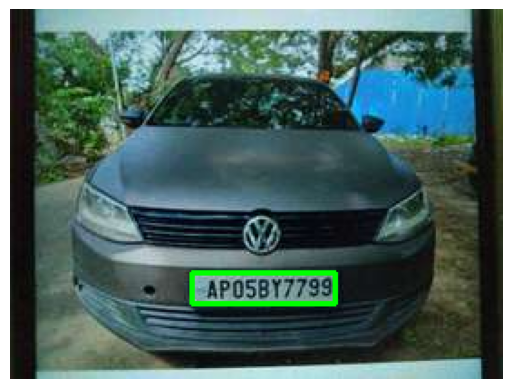

In [35]:

for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape
    
    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height
    
    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)
    
    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# After the loop, display the image with all bounding boxes
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image


In [ ]:
from ultralytics import YOLO
model=YOLO('yolov7')